<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/Station_Buildings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install --quiet pandas
!pip install --quiet matplotlib
!pip install -q osmnx
!pip install -q pydeck

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 754.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 35.4 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
from tqdm import tqdm
import pydeck as pdk
import shapely
import duckdb
import time

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

Deploy Flask apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


## Setup duckdb

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

In [4]:
%%sql
INSTALL httpfs;
INSTALL spatial;

,Success


## Download OSM data

In [5]:
## Note: the coordinates are in West, South, East, North format

bboxs = {
    'Mumbai': (72.7712628039,18.8895552464,73.0912396106,19.322318006),
    'Hyderabad': (78.2288393192,17.1952635128,78.692325037,17.6244114807),
    'Bangalore': (77.4480254838,12.815481916,77.7549560258,13.1026335949),
    'Chennai': (80.0337033915,12.8678089117,80.335827415,13.2370438819),
    'Kolkata': (88.2431406976,22.4883995072,88.4944529534,22.7071046611),
    'Ahmedabad': (72.4617185823,22.9179551449,72.699297928,23.1470216925),
    'Delhi_NCR': (76.881197,28.31444,77.604922,28.893765)
}

columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'name:hi', 'network', 'operator', 'public_transport',
       'ref', 'train','city']

## Select city
city = "Delhi_NCR"
W,S,E,N = bboxs[city]

In [6]:
%%time

public_transport = ox.features.features_from_bbox(
    bbox=(N,S,E,W),
    tags={
        'public_transport':['station', 'stop_position'],
        'railway': 'stop',
        'amenties': 'bus_station',
        'highway': 'bus_stop'
        }
).reset_index()

## Extract the station data:
pb = public_transport[public_transport['element_type']=='node'].copy()
columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'network', 'operator', 'public_transport',
       'ref', 'train']

pb_gdf = pb[columns]
pb_gdf = pb_gdf.fillna('None')
metro_stations = pb_gdf[pb_gdf['network'].str.lower().str.contains('metro')]
print("Total nodes with station tag:",metro_stations.shape[0])
metro_stations.sample(min(5,len(metro_stations)))

<timed exec>:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.


Total nodes with station tag: 763
CPU times: user 1.74 s, sys: 68.5 ms, total: 1.81 s
Wall time: 13.9 s


,element_type,osmid,geometry,railway,internet_access,name,network,operator,public_transport,ref,train
12,node,271335980,POINT (77.12578 28.48072),None,None,Arjan Garh,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,None,None
1673,node,5777630109,POINT (77.13925 28.67276),stop,None,Punjabi Bagh West,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,PBGW,None
1360,node,2837147020,POINT (77.13985 28.73838),station,None,"Rohini Sector 18, 19",Delhi Metro,Delhi Metro Rail Corporation Limited,station,RISE,None
2388,node,5777630970,POINT (77.30881 28.61345),None,None,Trilokpuri Sanjay Lake,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,None,None
1572,node,5737167170,POINT (77.22313 28.64247),stop,None,New Delhi Airport Express Terminal,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,NDI,None


Export the results

In [7]:
metro_stations.to_parquet('stations_stops.parquet')

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

In [8]:
pb_gdf.to_file('stations_stops.gpkg', driver='GPKG')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

## Corrected Station Locations

In [34]:
stations = gpd.read_file('stations_stops-corrected.gpkg', crs='EPSG:32642')
stations = stations.to_crs("EPSG:4326")
stations.head()

,osmid,name,railway,network,operator,geometry
0,4.950923e+09,Noida Sector 51,station,Noida Metro,NR,POINT (77.37529 28.58577)
1,1.007465e+10,Rainbow Metro Station,station,Noida Metro,NR,POINT (77.37820 28.57437)
2,4.950923e+09,Noida Sector 76,station,Noida Metro,NR,POINT (77.37961 28.56536)
3,4.950920e+09,Noida Sector 101,station,Noida Metro,NR,POINT (77.38494 28.55607)
4,4.950923e+09,Noida Sector 81,station,Noida Metro,NR,POINT (77.38993 28.54937)


In [36]:
print(metro_stations.shape, stations.shape)
dfx = pd.concat([metro_stations, stations])
dfx.drop(['osmid'], axis=1).to_parquet('stations-corrected.parquet')

(763, 11) (262, 6)


In [41]:
dfx.geometry.geom_type.unique()

array(['Point'], dtype=object)

## Download Station Buildings

Downloading the buildings from overturemaps using duckdb

The overture map's data keeps on updating month on month. Refer to the release notes to download the latest data: [lastest releases](https://docs.overturemaps.org/release/latest/)

[Download Overture Maps Data](https://overturemaps.org/download/)



In [42]:
%%time

buildings_data_url = r"'s3://overturemaps-us-west-2/release/2024-07-22.0/theme=buildings/type=*/*'"
stations_data_url = "'stations-corrected.parquet'"

df = duckdb.sql(
    f'''
    LOAD spatial;
    LOAD httpfs;
    COPY(
        SELECT
            id,
            names.primary as name,
            buildings.height as height,
            stations.name as station_name,
            stations.network as network,
            stations.operator as operator,
            stations.railway as railway,
            stations.public_transport as public_transport,
            ST_GeomFromWKB(buildings.geometry) as geom
        FROM read_parquet({buildings_data_url}, filename=true, hive_partitioning=1) AS buildings
        JOIN read_parquet({stations_data_url}) as stations
        ON ST_Intersects(ST_GeomFromWKB(buildings.geometry), ST_GeomFromWKB(stations.geometry))
        WHERE buildings.bbox.xmin > {W}
        AND buildings.bbox.xmax < {E}
        AND buildings.bbox.ymin > {S}
        AND buildings.bbox.ymax < {N}
    ) TO 'station_buildings.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
    '''
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 26.4 s, sys: 4.54 s, total: 30.9 s
Wall time: 3min 47s


In [43]:
sbf = gpd.read_file('station_buildings.geojson').drop_duplicates('geometry')  ## Unique Building footprints
print('Stations with enclosing buildings:', sbf.shape[0])
sbf.sample(5)

Stations with enclosing buildings: 233


,id,name,height,station_name,network,operator,railway,public_transport,geometry
409,08b3da106c80afff020027d515c3137f,None,None,Noida Sector 59,Delhi Metro,Delhi Metro Rail Corporation Limited,station,station,"POLYGON ((77.37268 28.60554, 77.37268 28.60554..."
496,08b3da1045a4dfff0200e29bb0de130e,None,None,Noida Sector 76,Noida Metro,NR,station,None,"POLYGON ((77.37975 28.56485, 77.37994 28.56487..."
326,08b3da112d0a3fff0200b736b902c925,None,None,Janakpuri East,Delhi Metro,Delhi Metro Rail Corporation Limited,stop,None,"POLYGON ((77.08724 28.63331, 77.08695 28.63320..."
576,08b3da1043230fff02001632d4271e1d,None,None,Noida Sector 83,Noida Metro,NR,station,None,"POLYGON ((77.39621 28.52255, 77.39621 28.52254..."
680,08b3da10e0636fff0200c294dfea6a12,None,None,Badhkal Mor,Delhi Metro,Delhi Metro Rail Corporation Limited,stop,None,"POLYGON ((77.31023 28.42209, 77.31047 28.42211..."


This will give all the building footprints surrounding the station nodes.
Note that buildings are based on overture maps which is not so well updated. There might me some stations without a enclosing building footprint

Let's find out those stations:

In [46]:
no_bf = stations[stations[['geometry']].sjoin(sbf, how='left', predicate='intersects').id.isna()].copy()
print('Stations without enclosing buildings:', no_bf.shape[0])
no_bf.sample(5)

Stations without enclosing buildings: 88


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


,osmid,name,railway,network,operator,geometry
91,6.548799e+09,Subhash Nagar,station,Delhi Metro,Delhi Metro Rail Corporation Limited,POINT (77.10490 28.64046)
210,4.335297e+09,Sant Surdas (Sihi),None,Delhi Metro,Delhi Metro Rail Corporation Limited,POINT (77.31625 28.35471)
199,2.833059e+09,Panchsheel Park,station,Delhi Metro,Delhi Metro Rail Corporation Limited,POINT (77.22044 28.54239)
149,5.626202e+08,Jawaharlal Nehru Stadium,None,Delhi Metro,Delhi Metro Rail Corporation Limited,POINT (77.23344 28.58933)
8,4.165777e+09,Noida Sector 143,station,Noida Metro,NR,POINT (77.42235 28.49431)


In [47]:
no_bf.to_file('stations_wo_BF.gpkg', driver='GPKG')

In [53]:
no_bf.to_parquet("stations_wo_BF.parquet")

<Axes: >

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


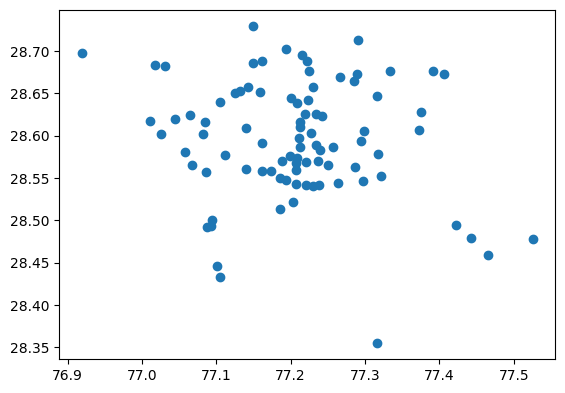

In [59]:
gpd.read_parquet("stations_wo_BF.parquet").plot()

## Download building footprints from VIDA


[Google-Microsoft Open Buildings - combined by VIDA](https://beta.source.coop/repositories/vida/google-microsoft-open-buildings/description/):

This dataset merges Google's V3 Open Buildings and Microsoft's latest Building Footprints. With 2,534,595,270 footprints, it is to our knowledge the most complete openly available dataset as of Sep. 2023. It covers 92% of Level 0 administrative boundaries, and is divided into 182 partitions. Each footprint is labelled with its respective source, either Google or Microsoft. It can be accessed in cloud-native geospatial formats such as GeoParquet, FlatGeobuf and PMTiles

In [48]:
duckdb.sql('INSTALL httpfs')
duckdb.sql('LOAD httpfs')
duckdb.sql('LOAD spatial')

In [49]:
W,S,E,N = 77.3031470176,28.4762710653,77.3070093985,28.4802649353

In [50]:
aoi = shapely.geometry.box(W,S,E,N)

aoi_file = 'aoi.geojson'
gpd.GeoSeries(aoi).to_file(aoi_file)

duckdb.sql(f"CREATE TABLE aoi AS SELECT * FROM ST_Read('{aoi_file}')")
duckdb.sql("SELECT * FROM aoi").show()

┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                         geom                                                         │
│                                                       geometry                                                       │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ POLYGON ((77.3070093985 28.4762710653, 77.3070093985 28.4802649353, 77.3031470176 28.4802649353, 77.3031470176 28.…  │
└──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



Load the building polygons

In [51]:
%%time
stations_data_url = "'stations_stops.parquet'"
prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
partitions = "by_country"
country_iso = "IND"

duckdb.sql(f'''
describe FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' AS buildings
''')

CPU times: user 79.9 ms, sys: 15.5 ms, total: 95.4 ms
Wall time: 1.34 s


┌────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name   │ column_type │  null   │   key   │ default │  extra  │
│    varchar     │   varchar   │ varchar │ varchar │ varchar │ varchar │
├────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ geometry       │ BLOB        │ YES     │ NULL    │ NULL    │ NULL    │
│ boundary_id    │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ bf_source      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ confidence     │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ area_in_meters │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ country_iso    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
└────────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [52]:
# stations_data_url = "'stations_stops.parquet'"
# prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
# partitions = "by_country"
# country_iso = "IND"

# query = f'''
# SELECT
# COUNT (*)
# FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' as buildings
# WHERE ST_Xmin(ST_GeomFromWKB(buildings.geometry)) > {W}
# AND ST_Xmax(ST_GeomFromWKB(buildings.geometry)) < {E}
# AND ST_Ymin(ST_GeomFromWKB(buildings.geometry)) > {S}
# AND ST_Ymax(ST_GeomFromWKB(buildings.geometry)) < {N};
# '''

# count = duckdb.sql(query)

In [60]:
start_time = time.time()

stations_data_url = "'stations_stops.parquet'"
prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
partitions = "by_country"
country_iso = "IND"

query = f'''
COPY(
    SELECT
    ST_Xmin(ST_GeomFromWKB(buildings.geometry)) as xmin,
    ST_Xmax(ST_GeomFromWKB(buildings.geometry)) as xmax,
    ST_Ymin(ST_GeomFromWKB(buildings.geometry)) as ymin,
    ST_Ymax(ST_GeomFromWKB(buildings.geometry)) as ymax,
    confidence,
    bf_source,
    ST_GeomFromWKB(buildings.geometry)
    FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' as buildings
    JOIN read_parquet({stations_data_url}) as stations
    ON ST_Within(ST_GeomFromWKB(stations.geometry), ST_GeomFromWKB(buildings.geometry))
    WHERE xmin > {W}
    AND xmax < {E}
    AND ymin > {S}
    AND ymax < {N}
) TO 'ML_station_buildings.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
'''

duckdb.sql(query)

end_time = (time.time()-start_time)/60

print(f"Time taken to process the request: {end_time:2f} mins")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Time taken to process the request: 20.051328 mins


In [61]:
gdf = gpd.read_file('ML_station_buildings.geojson')
print(gdf.shape)

(2, 7)


In [ ]:
gdf.sample(5)

,xmin,xmax,ymin,ymax,confidence,bf_source,geometry
234,77.129482,77.129995,28.636418,28.637716,0.8964,google,"POLYGON ((77.13000 28.63645, 77.12995 28.63671..."
324,77.169043,77.169964,28.588850,28.590031,0.8755,google,"POLYGON ((77.16996 28.58895, 77.16983 28.58914..."
124,77.145782,77.146423,28.672962,28.673130,0.7624,google,"POLYGON ((77.14642 28.67304, 77.14584 28.67310..."
362,77.325957,77.326368,28.570597,28.570958,0.8840,google,"POLYGON ((77.32637 28.57078, 77.32618 28.57096..."
212,77.199047,77.200726,28.643882,28.644744,0.9007,google,"POLYGON ((77.20072 28.64391, 77.20069 28.64392..."


In [ ]:
gpd.read_parquet('stations_stops.parquet')

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


,element_type,osmid,geometry,railway,internet_access,name,network,operator,public_transport,ref,train
0,node,249235041,POINT (77.04075 28.59225),stop,None,Dwarka Sector 12,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,DSW,None
1,node,249235042,POINT (77.03356 28.59702),stop,None,Dwarka Sector 13,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,DSTN,None
2,node,249823531,POINT (77.02599 28.60223),stop,None,Dwarka Sector 14,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,DSFN,None
7,node,271335327,POINT (77.07990 28.47952),None,None,M G Road,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,None,None
8,node,271335545,POINT (77.10227 28.48200),None,None,Guru Dronacharya,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,None,None
...,...,...,...,...,...,...,...,...,...,...,...
3196,node,9565595809,POINT (77.31645 28.34000),station,None,Raja Nahar Singh,Delhi Metro,Delhi Metro Rail Corporation Limited,station,None,None
3197,node,9597709830,POINT (77.26428 28.54455),station,None,Govind Puri,Delhi Metro,Delhi Metro Rail Corporation Limited,station,None,None
3198,node,9597709831,POINT (77.27535 28.54318),station,None,Harkesh Nagar Okhla,Delhi Metro,Delhi Metro Rail Corporation Limited,station,OKA,None
3199,node,9937948255,POINT (77.26484 28.55445),stop,None,Okhla NSIC,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,None,None
